# Lab 10.2 Object detection
by Domrachev Ivan, B20-Ro-01

In [1]:
from nn_from_scratch.optimizers import GradientDescent
from nn_from_scratch.examples.simple_nn import NeuralNetwork
from nn_from_scratch.nodes import ReLU, Vectorization, MSELoss, SoftMax
from nn_from_scratch.neurons import Linear, Convolution

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

## Part 1. New loss function

The new loss function, which was introduced in the lecture, looks like following:
$$l = \frac{1}{N} \sum_{i=1}^{N} (b_i - \hat{b}_i)^2$$

with back propogation:
$$\frac{dl}{db_i} = \frac{2}{N}*(b_i - \hat{b}_i)$$

This loss function was implemented in `nodes.py`, analogically to the previous node. Let's see how it works:

In [2]:
batch_size = 10
box_loss = MSELoss(input_size=(batch_size, 4))

x_input = np.random.randint(0, 255, size=(16, 4))
labels = np.random.randint(0, 255, size=(16, 4))
y_value = box_loss.forward(x_input, labels)
dL_dx = box_loss.backward(x_input)

print("Forward output:")
print(y_value)
print("Jacobian dL/dx:")
print(dL_dx)

Forward output:
[176256.25]
Jacobian dL/dx:
[[ -10.    69.5  -79.    47. ]
 [-108.5   18.5   -3.5  -40.5]
 [ -13.  -101.5   86.5  -52. ]
 [ -18.5  -18.5   93.   -12. ]
 [  -1.   -62.5  -68.     8. ]
 [ -35.5   16.5   22.5  -15. ]
 [ -31.5  -21.5   45.5  -66. ]
 [ -98.    14.   -26.5   56. ]
 [ -14.5  -36.    65.5  -14. ]
 [ -80.    -7.5   75.5  -21.5]
 [  -5.    13.5   93.5  -15.5]
 [  38.   -31.5    9.5  -59. ]
 [  34.    41.5   38.5   70. ]
 [ 112.5   30.   -58.   -41. ]
 [  63.    19.   -42.   -39.5]
 [  79.5 -101.   -10.   -25.5]]


## Part 2. The dataset


The dataset consists of photos of picachu, with bounding boxes of format (x0, y0, x1, y1). Let's load them into `np.array`s

In [3]:
import d2l
import sys
sys.path.insert(0, '..')
import d2l
import pandas as pd
import os
import json
import numpy as np
from PIL import Image

In [4]:
def load_dataset(dirname: str) -> tuple[np.ndarray, np.ndarray]:
    dataset = []
    annotations = []
    with open(dirname+'annotations.json') as fname:
        annotation_dict = json.load(fname)
    annotation_pd = pd.DataFrame.from_dict(annotation_dict, orient='index')

    for filepath in os.listdir(f'{dirname}/images'):
        img = np.array(Image.open(f'{dirname}/images/'+filepath).convert('RGB').resize((256, 256), Image.BILINEAR))
        bbox = annotation_pd.loc[annotation_pd['image']==filepath]['loc'][0]
        bbox = np.array([bbox[0], bbox[1], (bbox[2] - bbox[0]), (bbox[3] - bbox[1])])
        dataset.append(img)
        annotations.append(bbox)

    return np.array(dataset), np.array(annotations)

In [5]:
train_pic, train_ann = load_dataset('dataset/train/')
train_pic.shape, train_ann.shape

((900, 256, 256, 3), (900, 4))

In [6]:
val_pic, val_ann = load_dataset('dataset/val/')

In [7]:
def plot_img(pics, ann, i=0):
    fig, ax = plt.subplots(1, 1)
    ax.imshow(pics[i])
    rect = Rectangle(ann[i][0:2]*255, ann[i][2]*255, ann[i][3]*255, lw=1, edgecolor='r',facecolor='none')
    ax.add_patch(rect)

    plt.show()

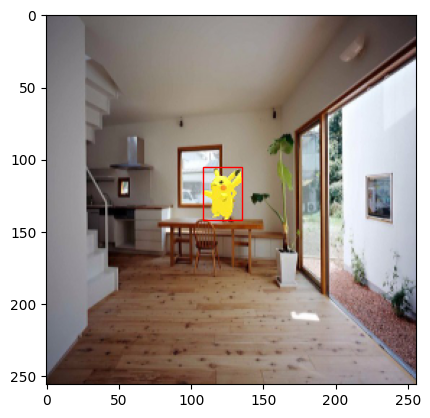

In [8]:
plot_img(train_pic, train_ann, i=np.random.randint(len(train_pic)))

## Part 3. Object detection

In [9]:
batch_size = 10
n_channels = 3
n_output = 4
train_pic = train_pic.reshape(train_pic.shape[0] // batch_size, batch_size, n_channels, 256, 256)
train_ann = train_ann.reshape(train_ann.shape[0] // batch_size, batch_size, 4)

In [10]:
train_pic = train_pic / 255

In [11]:
from nn_from_scratch.nodes import NormalizedSoftMax

In [12]:
gds = GradientDescent(lr=5e-2)
layers = [
    Convolution(
        (batch_size, n_channels, 256, 256), 
        kernel_size=3, 
        output_layers=4,
        use_bias=False
    ),
    ReLU((batch_size, 4, 254, 254)),
    Convolution(
        (batch_size, 4, 254, 254), 
        kernel_size=5,
        output_layers=2,
        use_bias=False
    ),
    ReLU((batch_size, 2, 250, 250)),
    Vectorization((batch_size, 2, 250, 250)),
    Linear((batch_size, 125000), (batch_size, n_output))
]
loss_fn = MSELoss((batch_size, n_output, ))
network = NeuralNetwork(
    n_input=28, 
    n_output=n_output, 
    batch_size=batch_size, 
    optimizer=gds,
    layers=layers,  
    loss_fn=loss_fn
)
network.fit(train_pic, train_ann, n_epochs=5)

  0%|          | 0/90 [00:00<?, ?it/s]

100%|██████████| 90/90 [03:16<00:00,  2.18s/it, loss=0.0524]


Epoch 1, Loss: 0.052375725857173344


 80%|████████  | 72/90 [02:41<00:40,  2.24s/it, loss=0.0301]


KeyboardInterrupt: 

In [13]:
val_pic = val_pic.reshape(val_pic.shape[0] // batch_size, batch_size, n_channels, 256, 256)
val_ann = val_ann.reshape(val_ann.shape[0] // batch_size, batch_size, 4)

In [14]:
pic_preds = network.predict(val_pic[0])
pic_preds[0]*255

array([114.032135,  97.88838 ,  25.943707,  39.67746 ], dtype=float32)

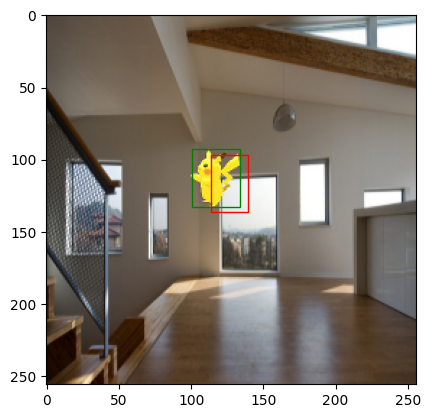

In [15]:
fig, ax = plt.subplots(1, 1)
ax.imshow(val_pic[0, 1].reshape(256, 256, 3))
rect = Rectangle((val_ann[0, 1][0:2])*255, (val_ann[0, 1][2])*255, (val_ann[0,1][3])*255, lw=1, edgecolor='g',facecolor='none')
rect_pred = Rectangle((pic_preds[1][0:2])*255, (pic_preds[1][2])*255, (pic_preds[1][3])*255, lw=1, edgecolor='r',facecolor='none')
ax.add_patch(rect)
ax.add_patch(rect_pred)

plt.show()

I think that the result is quite decent